# Review

## The `minimize` function in `scipy.optimize`
`minimize(f, x0)` minimizes $f(x)$ with an initial guess $x_0$
  * if $f(x)$ is a multivariable function, then $x$ is an array

### Optional keyword arguments
* **bounds**: a list of bounds (min, max) for each variable, 
  * use (None, None) for a variable with no bounds
  * use (l, None) for $x\geq l$
  * use (None, u) for $x\leq u$

### Return value
An object with the following instance variables:
* **x**: The solution of the optimization.
* **success**: a boolean indicating whether or not the optimizer exited successfully.
* **message**: Description of the cause of the termination.
* **fun**: Values of objective function, its Jacobian and its Hessian (if available). The Hessians may be approximations
* others that are not quite relevant to this lab 

# Example

The attached "Piladelphia-1918.csv" contains the daily number of flu deaths during the 1918 pandemic of influenza A/H1N1 in philadelpha. The first column is the day (in the unit of a year), the second column is the number of deaths on that day.


Text(0.5, 1.0, 'daily flu deaths, log scale')

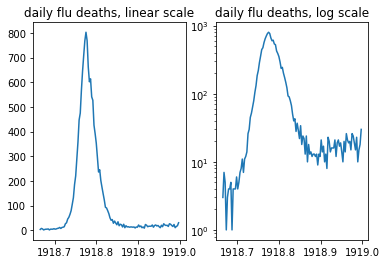

In [2]:
from pandas import read_csv
data = read_csv("Philadelphia-1918.csv", sep=" ", names=["t", "x"])

from matplotlib.pyplot import subplots
fig, ax = subplots(1, 2) # 1 row, 2 columns
ax[0].plot(data.t, data.x)
ax[0].set_title("daily flu deaths, linear scale")
ax[1].semilogy(data.t, data.x)
ax[1].set_title("daily flu deaths, log scale")


# Estimating the exponential growth rate
The initial stage of the epidemic exhibits an exponential growth. We estimate the exponential growth rate using Poisson regression, i.e, assuming that each observation is independently Poisson distributed with a mean 
$$f(t;a,r)=ae^{rt}$$

The probaility of observing the number of deaths $x_i$ on day $t_i$ with parameter values $(a,r)$, is
$$P(X_i=x_i)=\frac{e^{-f(t_i;a,r)}f(t_i;a,r)^{x_i}}{x_i!}$$

Because of the independence assumption, the probability of observing all the data, i.e., the likelihood function, is the product of these probabilities
$$L(a,r)=\prod_{i=1}^nP(X_i=x_i)=\prod_{i=1}^n\frac{e^{-f(t_i;a,r)}f(t_i;a,r)^{x_i}}{x_i!}$$

* Note that the probabilities are $<1$, so $L(a,r)$ may be very close to 0. This means that rounding error may become significant. 

To avoid the infleunce of rounding errors, we maximize
$$
\ell(a,r) =\ln L(a, r) = \sum_{i=1}^n-f(t_i;a,r)+x_i\ln f(t_i;a,r)-\ln x_i!
$$

To maximize $\ell(a,r)$ is equivalent to minimize $-\ell(a,r)$. In addition, since the observations $x_i$ are constants, $\ln x_i!$ do not change the solution to $(a,r)$. Thus
$$\min_{a,r} \sum_{i=1}^n f(t_i;a,r) - x_i\ln f(t_i;a,r)$$

We use $t_i=0,1,2,...$, i.e., the days since the start of the data.

In [1]:
from scipy.optimize import minimize
from numpy import exp, log, arange

n = 30 # use n data points
t = arange(0, n) # 0, 1, 2,..., n-1
x = data.x[0:n]

f = lambda t, p: p[0]*exp(p[1]*t) # p[0] = a, p[1] = r

negl = lambda p: sum(f(t, p) - x*log(f(t, p)))

m = minimize(negl, [3, 1])
print(m)

NameError: name 'data' is not defined

      fun: -1858.0562695874958
 hess_inv: array([[ 1.19348261e-02, -7.72002627e-04],
       [-7.72002627e-04,  5.23988576e-05]])
      jac: array([-0.00010681,  0.00059509])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 315
      nit: 51
     njev: 76
   status: 2
  success: False
        x: array([0.61484664, 0.17851263])


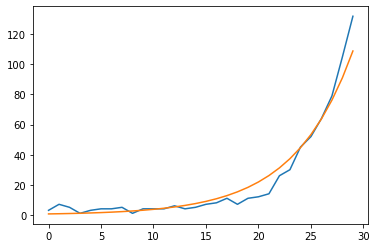

In [10]:
m = minimize(l, [3, 1])
print(m)

from matplotlib.pyplot import plot
plot(t, x, t,  f(t, m.x))

      fun: -8965.17959357784
 hess_inv: array([[ 1.82005662e-03, -2.16939820e-04],
       [-2.16939820e-04,  2.63628934e-05]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 184
      nit: 25
     njev: 46
   status: 0
  success: True
        x: array([0.27553406, 0.21552522])


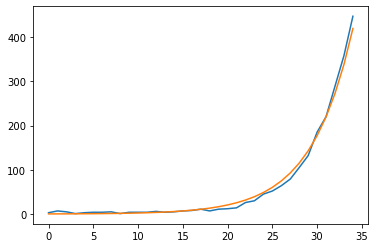

In [11]:
n = 35 # use n data points
t = arange(0, n) # 0, 1, 2,..., n-1
x = data.x[0:n]

m = minimize(l, [3, 0.3])
print(m)
plot(t, x, t,  f(t, m.x))

# Group assignment

The example shows that there is no good rule for determining how many data points to use. To solve this problem, we assume that a logistic model describes the cumulative death curve, i.e.,
$$y(t;a, r) = \frac{K}{1+(\frac K a-1)e^{-rt}}$$
where $K$ is the total number of cases. So $K$ is the sum of all case counts in the spread sheet. (i.e, `K=sum(data.x)`)

The mean deaths $$f(t_i;a, r)=y(t_{i+1}; a, r)-y(t_i; a, r)$$

We fit from the start to the peak of the death curve for the parameters $a, r$
* i.e, use `n=list(data.x).index(max(data.x)) + 1`


Other considerations
* You need to use one more time point for $y$, so that the difference of $y$ corresponds to the observations
* You may need to give bounds $a\geq 0$, $r\geq 0$
* You may encounter error that arised when $a<0$ during the optimization process. So you may want to pass bounds to require that all parameters are nonnegative.

      fun: -30790.540384421012
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00254659, -0.03237801])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 72
      nit: 20
   status: 0
  success: True
        x: array([0.58742581, 0.23956142])


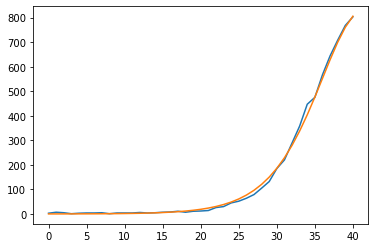

In [24]:
from numpy import diff
n = list(data.x).index(max(data.x)) + 1
K = sum(data.x)

t = arange(0, n+1) # 0, 1, 2,..., n
x = data.x[0:n]

y = lambda t, p: K / (1 + (K/p[0]-1)*exp(-p[1]*t)) # p[0] = a, p[1] = r
f = lambda t, p: diff(y(t, p))

l = lambda p: sum(f(t, p) - x*log(f(t, p)))

m = minimize(l, [3, 0.2], bounds=[(0, None), (0, None)])
print(m)

plot(t[0:n], x, t[0:n], f(t, m.x))